In [55]:
# %cd ~/src/Sunrise-Demo/
from __future__ import annotations
try:
    from mediocreatbest import auto, run
except ImportError:
    %pip install --quiet --upgrade pip
    %pip install --upgrade --force-reinstall \
        mediocreatbest@git+https://gist.github.com/player1537/3457b026ed6ef6696d758517f55a58df.git
from mediocreatbest import auto, run

In [56]:
SPECIES = "0000143"
TIXEL_Z = 21
ZOOM_RESOLUTION = 5
SHELVE_PATH = auto.pathlib.Path.cwd() / 'elevation-shelve' / 'Sunrise.shelve'

DO_SAVE = True
TERRAIN_QUALITY = (
    0
    # 1
    # 2
)
VIDEO_QUALITY = (
#     0
#     1
    2
)

# # Zoom level 13
# RLO=824832
# RHI=827647
RLO=823296
RHI=829438
# CLO=559104
CLO=558080
# CHI=564479
CHI=566270

# # Zoom level 15
# RLO=3300096
# RHI=3310591
# CLO=2236928
# CHI=2259455

## Setup

In [57]:
%%scope
def string_function(arr):
    name = arr.__class__.__name__
    if arr.size < 1024:
        values = auto.numpy.array_repr(auto.numpy.ravel(arr))
    else:
        values = '...'
        
    shape = auto.numpy.shape(arr)
    dtype = arr.dtype
    return f'{name}({values}, {shape=!r}, {dtype=!r})'
auto.numpy.set_string_function(string_function, repr=False)
auto.numpy.set_string_function(string_function, repr=True)

auto.numpy.set_printoptions(
    threshold=4,
    edgeitems=0,
)

### Typing

In [58]:
Degree = auto.typing.NewType('Degree', float)
Radian = auto.typing.NewType('Radian', float)
Meter = auto.typing.NewType('Meter', float)
Kilometer = auto.typing.NewType('Kilometer', float)

## Location (lat, lng, alt) to spatial (x, y, z)

In [59]:
def convert_location_to_spatial(
    *,
    lat: Degree,
    lng: Degree,
    alt: Meter,
    math=auto.math,
) -> Tuple[Meter, Meter, Meter]:
    # Thanks https://gis.stackexchange.com/a/4148
    
    #> Note that "Lat/Lon/Alt" is just another name for spherical coordinates, and 
    #> phi/theta/rho are just another name for latitude, longitude, and altitude.
    #> :) (A minor difference: altitude is usually measured from the surface of the 
    #> sphere; rho is measured from the center -- to convert, just add/subtract the 
    #> radius of the sphere.)
    phi: Radian = math.radians(lat)
    theta: Radian = math.radians(lng)
    
    # Thanks https://en.wikipedia.org/wiki/Earth_radius
    #> A globally-average value is usually considered to be 6,371 kilometres (3,959 mi)
    rho: Meter = 6_371_000 + alt
    
    #> x = math.cos(phi) * math.cos(theta) * rho
    x: Meter = math.cos(phi) * math.cos(theta) * rho
    
    #> y = math.cos(phi) * math.sin(theta) * rho
    y: Meter = math.cos(phi) * math.sin(theta) * rho

    #> z = math.sin(phi) * rho # z is 'up'
    z: Meter = math.sin(phi) * rho
    
    #> (Note there's some slightly arbitrary choices here in what each axis means...
    #> you might want 'y' to point at the north pole instead of 'z', for example.)
    
    # I do :)
    y, z = z, y
    
    return x, y, z

In [60]:
@auto.mediocreatbest.doctest
def convert_tile_coordinates_to_latlng(
    *,
    z: int,
    x: int,
    y: int,
    math=auto.numpy,
    return_google_maps_url: bool=False,
) -> Tuple[Degree, Degree]:
    # r"""

    # >>> convert_tile_coordinates_to_latlng(z=15, x=8739, y=12925, return_google_maps_url=True)
    # 'https://www.google.com/maps/@35.48751102385376,-83.990478515625,15.79z?entry=ttu'

    # """
    
    # Thanks https://gis.stackexchange.com/a/133535
    
    #> n = 2 ^ zoom
    n = 2 ** z
    
    #> lon_deg = xtile / n * 360.0 - 180.0
    lon_deg = x / n * 360.0 - 180.0

    print("LATLNG")
    
    #> lat_rad = arctan(sinh(π * (1 - 2 * ytile / n)))
    lat_rad = math.arctan(math.sinh(math.pi * (1.0 - 2.0 * y / n)))
    
    #> lat_deg = lat_rad * 180.0 / π
    lat_deg = lat_rad * 180.0 / math.pi
    
    if return_google_maps_url:
        return f"""https://www.google.com/maps/@{lat_deg},{lon_deg},15.79z?entry=ttu"""
    
    return lat_deg, lon_deg

### Dataclasses

In [61]:
@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Coord:
    """Tile image coordinates for mapbox/etc services"""
    z: int
    x: int
    y: int

    @property
    def nw(self) -> Location:
        """North-West lat/lng of current tile"""
        lat, lng = tile_coordinates_to_latlng(
            z=self.z,
            x=self.y,
            y=self.x,
            # z=self.z,
            # x=self.x,
            # y=self.y,
        )
        return Location(lat=lat, lng=lng)

    @property
    def se(self) -> Location:
        """South-East lat/lng of current tile"""
        lat, lng = tile_coordinates_to_latlng(
            z=self.z,
            x=1+self.y,
            y=1+self.x,
            # z=self.z,
            # x=1+self.x,
            # y=1+self.y,
        )
        return Location(lat=lat, lng=lng)

In [62]:
@auto.dataclasses.dataclass(eq=True, frozen=True)
class Domain:
    """Lower (inclusive) and upper (inclusive) bounds of latitude/longitude"""
    lo: Coord
    hi: Coord
        
    @property
    def coords(self) -> List[Coord]:
        """All coordinates within lower/upper bounds"""
        coords = []
        for z, x, y in auto.itertools.product(
            range(self.lo.z, 1+self.hi.z),
            range(self.lo.x, 1+self.hi.x),
            range(self.lo.y, 1+self.hi.y),
        ):
            coords.append(Coord(
                z=z,
                x=x,
                y=y,
            ))
        
        return coords

In [63]:
@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Location:
    """Geographical latitude/longitude"""
    lat: Degree
    lng: Degree
    alt: Optional[Meter] = auto.dataclasses.field(default=None)

In [64]:
@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Point:
    x: Kilometer
    y: Kilometer
    z: Kilometer

In [65]:
# @dispatch
@auto.dataclasses.dataclass(eq=True, order=True, frozen=True)
class Tixel:
    y: int
    x: int
        
    # z: ClassVar[int] = 23
    z: ClassVar[int] = TIXEL_Z
        
    @property
    def location(self) -> Location:
        """Center lat/lng of current tixel"""
        lat, lng = tile_coordinates_to_latlng(
            z=1+self.z,
            x=1+self.x,
            y=1+self.y,
        )
        return Location(lat=lat, lng=lng)

# @Tixel.register
# def __tixel_from_coord(coord: Coord, /, *, res: int):
#     dz = int(auto.math.log2(Tixel.z - coord.z))
    

In [66]:
@auto.dataclasses.dataclass
class TileURL:
    scheme: str
    netloc: str
    prefix: str
    z: int
    x: int
    y: int
    suffix: str
    query: Dict[str, str]
    fragment: str

    @classmethod
    @auto.mediocreatbest.doctest
    def decode(cls, url: str) -> Self:
        r"""
        
        >>> decode(dict, 'https://atlas-stg.geoplatform.gov/styles/v1/atlas-user/ck58pyquo009v01p99xebegr9/tiles/256/11/549/806@2x?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')
        ... # doctest: +NORMALIZE_WHITESPACE
        {'scheme': 'https',
         'netloc': 'atlas-stg.geoplatform.gov',
         'prefix': ['', 'styles', 'v1', 'atlas-user', 'ck58pyquo009v01p99xebegr9', 'tiles', '256'],
         'z': 11,
         'x': 549,
         'y': 806,
         'suffix': '@2x',
         'query': [('access_token',
                    'pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')],
         'fragment': ''}
        >>> decode(dict, 'https://atlas-stg.geoplatform.gov:443/v4/atlas-user.0000214_pink/11/549/806.png?access_token=pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')
        ... # doctest: +NORMALIZE_WHITESPACE
        {'scheme': 'https',
         'netloc': 'atlas-stg.geoplatform.gov:443',
         'prefix': ['', 'v4', 'atlas-user.0000214_pink'],
         'z': 11,
         'x': 549,
         'y': 806,
         'suffix': '.png',
         'query': [('access_token',
                    'pk.eyJ1IjoiYXRsYXMtdXNlciIsImEiOiJjazFmdGx2bjQwMDAwMG5wZmYwbmJwbmE2In0.lWXK2UexpXuyVitesLdwUg')],
         'fragment': ''}
        
        """
        
        scheme, netloc, path, query, fragment = auto.urllib.parse.urlsplit(
            url,
        )
        path = path.split('/')
        *prefix, z, x, suffix = path
        assert (match := auto.re.match(r'^(\d+)(.*)$', suffix)) is not None, \
            f'{suffix = !r}'
        y, suffix = match.groups()
            
        
        z, x, y = map(int, (z, x, y))
        query = auto.urllib.parse.parse_qsl(
            query,
        )

        return cls(
            scheme=scheme,
            netloc=netloc,
            prefix=prefix,
            z=z,
            x=x,
            y=y,
            suffix=suffix,
            query=query,
            fragment=fragment,
        )

    def encode(self) -> str:
        query = auto.urllib.parse.urlencode(
            self.query,
            doseq=True,
        )
        
        z, x, y = map(str, (self.z, self.x, self.y))

        path = '/'.join([
            *self.prefix,
            z,
            x,
            y + self.suffix,
        ])

        return auto.urllib.parse.urlunsplit((
            self.scheme,
            self.netloc,
            path,
            query,
            self.fragment,
        ))
    

In [67]:
## @Tile.from_.register(Location)
@auto.mediocreatbest.doctest
def convert_location_to_tile(*, lat: Degree, lng: Degree, zoom: int, math=auto.math) -> tuple[int, int]:
    r"""
    
    >>> convert_location_to_tile(lat=35.6, lng=-83.52, zoom=11)
    (807, 548)
    >>> convert_location_to_tile(lat=35.0, lng=-84.5, zoom=15)
    (12979, 8692)
    >>> convert_location_to_tile(lat=36.25, lng=-82.5, zoom=15)
    (12839, 8874)
    
    """
    # Thanks https://stackoverflow.com/a/72476578
    
    #> lat_rad = math.radians(lat_deg)
    lat_rad = math.radians(lat)
    
    #> n = 2.0 ** zoom
    n = 2.0 ** zoom
    
    #> xtile = int((lon_deg + 180.0) / 360.0 * n)
    col = int((lng + 180.0) / 360.0 * n)
    
    #> ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    row = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    
    #> return (xtile, ytile)
    return row, col

    

## HTTP Request Caching

In [68]:
@run(once=True)
def cache():
    path = SHELVE_PATH
    # path = auto.pathlib.Path.cwd() / 'background' / 'Sunrise.shelve'
    return auto.shelve.open(str(path), 'c')

In [69]:
@run
def fetch(cache, /):
    def fetch(url: str, *, tqdm=None) -> bytes:
        key = url
        if key not in cache:
            if tqdm is not None:
                tqdm.set_description(f'Cache Miss: {url}')

            # with auto.requests.get(url) as r:
            #     r.raise_for_status()
            #     cache[key] = r.content
            try:
                r = auto.requests.get(url)
                r.raise_for_status()
                content = r.content
            except auto.requests.exceptions.HTTPError:
                content = 404
            
            cache[key] = content
            auto.time.sleep(1)
        
        else:
            if tqdm is not None:
                tqdm.set_description('Cache Hit: {url}')
            
            content = cache[key]
        
        if isinstance(content, int):
            # raise auto.requests.exceptions.HTTPError(content)
            return None
        
        return content

    return fetch

In [70]:
def __stitch_tiles(tiles, /, size: int=128, flip=False):
    auto.PIL; from PIL import Image
    
    xs = set(tile.coord.x for tile in tiles)
    ys = set(tile.coord.y for tile in tiles)
    
    xs = sorted(xs)
    ys = sorted(ys)
    
    nx = len(xs)
    ny = len(ys)
    
    sz = size
    
    composite = Image.new('RGB', (nx*sz, ny*sz))
    
    for tile in tiles:
        xi = xs.index(tile.coord.x)
        yi = ys.index(tile.coord.y)
        
        with auto.io.BytesIO(tile.image) as f:
            try:
                image = Image.open(f)
            except auto.PIL.UnidentifiedImageError:
                continue

            image.thumbnail((sz, sz))

        # composite.paste(image, (yi*sz, xi*sz))
        if flip==True:
            composite.paste(image, (yi*sz, xi*sz))
        else:
            composite.paste(image, (xi*sz, yi*sz))
            
    
    return composite

In [71]:
## @Tile.from_.register(Location)
@auto.mediocreatbest.doctest
def convert_location_to_tile(*, lat: Degree, lng: Degree, zoom: int, math=auto.math) -> tuple[int, int]:
    r"""
    
    >>> convert_location_to_tile(lat=35.6, lng=-83.52, zoom=11)
    (807, 548)
    >>> convert_location_to_tile(lat=35.0, lng=-84.5, zoom=15)
    (12979, 8692)
    >>> convert_location_to_tile(lat=36.25, lng=-82.5, zoom=15)
    (12839, 8874)
    
    """
    # Thanks https://stackoverflow.com/a/72476578
    
    #> lat_rad = math.radians(lat_deg)
    lat_rad = math.radians(lat)
    
    #> n = 2.0 ** zoom
    n = 2.0 ** zoom
    
    #> xtile = int((lon_deg + 180.0) / 360.0 * n)
    col = int((lng + 180.0) / 360.0 * n)
    
    #> ytile = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    row = int((1.0 - math.asinh(math.tan(lat_rad)) / math.pi) / 2.0 * n)
    
    #> return (xtile, ytile)
    return row, col

## Elevation

In [72]:
@run(scope='elevation', after=print)
# @auto.mediocreatbest.doctest
def domain(z=5):
    # z = 2
    # r'''
    # >>> domain(z=0)
    # Domain(lo=Coord(z=0, x=0, y=0), hi=Coord(z=0, x=0, y=0))
    # >>> domain(z=1)
    # Domain(lo=Coord(z=1, x=0, y=0), hi=Coord(z=1, x=1, y=1))
    # >>> domain(z=2)
    # Domain(lo=Coord(z=2, x=0, y=0), hi=Coord(z=2, x=3, y=3))
    # >>> sum(1 for _ in domain(z=0).coords)
    # 1
    # >>> sum(1 for _ in domain(z=1).coords)
    # 4
    # >>> sum(1 for _ in domain(z=2).coords)
    # 16
    # >>> sum(1 for _ in domain(z=3).coords)
    # 64
    # '''
    return Domain(
        lo=Coord(z=11, x=546-1, y=805-1),
        hi=Coord(z=11, x=551+1, y=808+1),
        # lo=Coord(z=z, x=0, y=0),
        # hi=Coord(z=z, x=(2**z)-1, y=(2**z)-10),
    )

@run(scope='elevation')
def tiles(domain, fetch, /):
    def make_url(coord: Coord, /, *, url=TileURL.decode(
        r"""https://api.mapbox.com/v4/mapbox.terrain-rgb/14/3826/6127@2x.pngraw?access_token=pk.eyJ1IjoidGhvYnNvbjIiLCJhIjoiY2oxZmdqbnQzMDBpbjJxczR6dWoyemUxNiJ9.SEBHSdHLP_lZGD43r-_IDQ"""
    )) -> URL:
        return auto.dataclasses.replace(
            url,
            z=coord.z,
            x=coord.x,
            y=coord.y,
        )
    
    tiles = []
    for coord in (tqdm := auto.tqdm.tqdm(domain.coords)):
        url = make_url(coord).encode()
        image = fetch(url, tqdm=tqdm)
        
        tiles.append(Tile(
            coord=coord,
            url=url,
            image=image,
        ))
    
    return tiles

Domain(lo=Coord(z=11, x=545, y=804), hi=Coord(z=11, x=552, y=809))


Cache Hit: {url}: 100%|██████████| 48/48 [00:00<00:00, 423.02it/s]


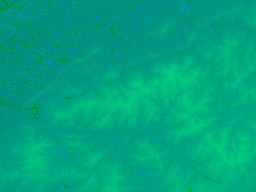

In [73]:
__stitch_tiles(auto.mediocreatbest.g['elevation__tiles'], size=32)

In [74]:
@run(scope='elevation')
def interpolator(tiles, /):
    res = 512
    
    def tile_altitude(tile: Tile, /) -> auto.numpy.NDArray[auto.numpy.float32]:
        with auto.io.BytesIO(tile.image) as f:
            image = auto.PIL.Image.open(f)
            image = auto.PIL.ImageOps.flip(image) # flip the tile vertically because we reverse the order as well
            image.load()
        
        image = image.convert('RGB')
        
        rgb = auto.numpy.array(image)
        assert len(rgb.shape) == 3, \
            f"""Expected dimension 3: {rgb.shape=!r}"""
        assert rgb.shape[0] == rgb.shape[1], \
            f"""Expected square image: {rgb.shape=!r}"""
        assert rgb.shape[0] == res, \
            f"""Expected resolution: {res}; Got resolution: {rgb.shape[0]}"""
        assert rgb.shape[2] == 3, \
            f"""Expected last component to be rgb values: {rgb.shape=!r}"""
        assert rgb.dtype == auto.numpy.uint8, \
            f"""Expected dtype to be uint8_t: {rgb.dtype=!r}"""
        
        # Thanks https://docs.mapbox.com/data/tilesets/guides/access-elevation-data/#decode-data
        #> elevation = -10000 + (({R} * 256 * 256 + {G} * 256 + {B}) * 0.1)
        
        altitude = auto.numpy.zeros(
            shape=(rgb.shape[0], rgb.shape[1]),
            dtype=auto.numpy.float32,
        )
        
        altitude += rgb[:, :, 0] * (1 * 256 * 256)
        altitude += rgb[:, :, 1] * (1 * 256)
        altitude += rgb[:, :, 2] * (1)
        altitude *= 0.1
        altitude -= 10000
        
        return altitude

    xs = sorted(set(tile.coord.x for tile in tiles))
    # Reverse sort elevation tiles on the y because for some reason they orient upside down from typical mercator proj 
    ys = sorted(set(tile.coord.y for tile in tiles))
    ys = ys[::-1]
    zs = sorted(set(tile.coord.z for tile in tiles))
    
    assert len(zs) == 1
    z ,= zs
    
    print(f'{z=!r}')
    
    dz = int(auto.math.log2(res))
    print(f'{dz=!r} {res=!r}')
    points = (
        auto.numpy.arange(
            (min(ys) + 0) * 2 ** dz,
            (max(ys) + 1) * 2 ** dz,
        ),
        auto.numpy.arange(
            (min(xs) + 0) * 2 ** dz,
            (max(xs) + 1) * 2 ** dz,
        ),
    )
    z += dz
    print(f'{z=!r}')
    
    print(f'{points[0][0]=!r}')
    print(f'{points[0][-1]=!r}')
    
    if z < Tixel.z:
        dz = Tixel.z - z
        print(f'{dz=!r}')
        points = (
            points[0] * 2 ** dz,
            points[1] * 2 ** dz,
        )
        z += dz
        print(f'{z=!r}')
        
        print(f'{points[0][0]=!r}')
        print(f'{points[0][-1]=!r}')
    
    assert z == Tixel.z
    
    values = auto.numpy.zeros(
        shape=(
            len(ys)*res,
            len(xs)*res,
        ),
        dtype=auto.numpy.float32,
    )
    
    for tile in tiles:
        xi = xs.index(tile.coord.x)
        yi = ys.index(tile.coord.y)
        
        values[
            slice(
                (yi + 0) * res,
                (yi + 1) * res,
            ),
            slice(
                (xi + 0) * res,
                (xi + 1) * res,
            ),
        ] = tile_altitude(tile)

    return auto.scipy.interpolate.RegularGridInterpolator(
        points=points,
        values=values,
        bounds_error=False,
        fill_value=0,
    )

z=11
dz=9 res=512
z=20
points[0][0]=411648
points[0][-1]=414719
dz=1
z=21
points[0][0]=823296
points[0][-1]=829438


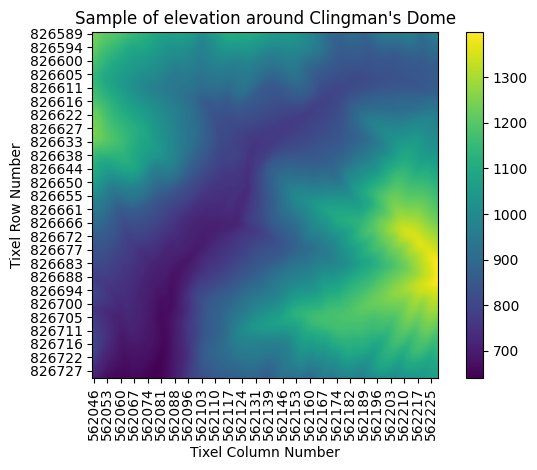

In [75]:
@run
def __visualize(elevation__interpolator, /):
    def visualize(
        *,
        name: str,
        interpolator: auto.scipy.interpolate.RegularGridInterpolator,
        num: int,
    ):
        lat0, lng0 = 35.572785, -83.518351
        lat1, lng1 = 35.553081, -83.487097
        
        r0, c0 = convert_location_to_tile(
            lat=lat0,
            lng=lng0,
            zoom=Tixel.z,
        )
        
        r1, c1 = convert_location_to_tile(
            lat=lat1,
            lng=lng1,
            zoom=Tixel.z,
        )
        
        rlo, rhi = min(r0, r1), max(r0, r1)
        clo, chi = min(c0, c1), max(c0, c1)

        # real_rlo = interpolator.grid[0].min()
        # real_rhi = interpolator.grid[0].max()
        # real_clo = interpolator.grid[1].min()
        # real_chi = interpolator.grid[1].max()
        # assert rlo >= real_rlo, \
        #     f'{rlo=!r} < {real_rlo=!r}'
        # assert rhi <= real_rhi, \
        #     f'{rhi=!r} > {real_rhi=!r}'
        # assert clo >= real_clo, \
        #     f'{clo=!r} < {real_clo=!r}'
        # assert chi <= real_chi, \
        #     f'{chi=!r} > {real_chi=!r}'

    # rs = auto.numpy.arange(rlo, rhi)
    # cs = auto.numpy.arange(clo, chi)

        
        rs = auto.numpy.linspace(rlo, rhi, num=num)
        cs = auto.numpy.linspace(clo, chi, num=num)
        
        grid = auto.numpy.hstack(tuple(
            v.reshape((-1, 1))
            for v in auto.numpy.meshgrid(
                rs,
                cs,
                indexing='ij',
            )
        ))
        assert grid.shape == (len(cs)*len(rs), 2), \
            f"""Wrong shape: {grid.shape=!r}"""
        
        values = interpolator(grid)
        values = values.reshape((len(rs), len(cs), -1))
        
        %matplotlib inline
        plt = auto.matplotlib.pyplot
        
        fig = plt.figure()
        ax = fig.add_subplot(111)
        im = ax.imshow(values)
        ax.set_yticks(auto.numpy.arange(0, len(rs), 5))
        ax.set_yticklabels([f'{int(r)}' for r in rs[::5]], rotation=0)
        ax.set_xticks(auto.numpy.arange(0, len(cs), 5))
        ax.set_xticklabels([f'{int(c)}' for c in cs[::5]], rotation=90)
        
        ax.set_title(f"Sample of {name} around Clingman's Dome")
        ax.set_xlabel('Tixel Column Number')
        ax.set_ylabel('Tixel Row Number', rotation=90)
        
        fig.colorbar(im)
        fig.tight_layout()
        plt.show()
    
    visualize(
        name='elevation',
        interpolator=elevation__interpolator,
        num=128,
    )
    
    

In [76]:
@run(scope='render', after=print)
def terrain(elevation__interpolator, /):
    """mesh/OSPGeometry:mesh:position/vertex.position:vec3f[]+index/index:vec4ui[]"""
    # rlo, rhi = 3300096, 3310591
    # clo, chi = 2236928, 2259455

    # real_rlo = interpolate.elevation.grid[0].min()
    # real_rhi = interpolate.elevation.grid[0].max()
    # real_clo = interpolate.elevation.grid[1].min()
    # real_chi = interpolate.elevation.grid[1].max()
    # real_rlo = interpolate.observation.grid[0].min()
    # real_rhi = interpolate.observation.grid[0].max()
    # real_clo = interpolate.observation.grid[1].min()
    # real_chi = interpolate.observation.grid[1].max()
    # real_rlo = interpolate.background.grid[0].min()
    # real_rhi = interpolate.background.grid[0].max()
    # real_clo = interpolate.background.grid[1].min()
    # real_chi = interpolate.background.grid[1].max()
    # assert rlo >= real_rlo, \
    #     f'{rlo=!r} < {real_rlo=!r}'
    # assert rhi <= real_rhi, \
    #     f'{rhi=!r} > {real_rhi=!r}'
    # assert clo >= real_clo, \
    #     f'{clo=!r} < {real_clo=!r}'
    # assert chi <= real_chi, \
    #     f'{chi=!r} > {real_chi=!r}'

    # rs = auto.numpy.arange(rlo, rhi)
    # cs = auto.numpy.arange(clo, chi)
    # rs = auto.numpy.arange(real_rlo, real_rhi)
    # cs = auto.numpy.arange(real_clo, real_chi)
    rs = auto.numpy.arange(RLO, RHI)
    cs = auto.numpy.arange(CLO, CHI)
    print(f'RS: {rs}')
    print(f'CS: {cs}')

    def decimate(
        rs: auto.np.ndarray,
        cs: auto.np.ndarray,
        /,
        *,
        duration: 'seconds',
        rate: 'item/s',
    ) -> tuple[auto.np.ndarray, auto.np.ndarray]:
        total_items = len(rs) * len(cs)

        actual_items = duration * rate
    #             print(f'{items = } = {duration} * {rate}')

        factor_items = total_items / actual_items

        stride = int(auto.math.ceil(auto.math.sqrt( factor_items )))

    #             stride = int(auto.math.ceil())
    #             print(f'{stride = } = int(auto.math.ceil( {len(rs)} / {items} == {len(rs)/items} ))')

        rs = rs[::stride]
        cs = cs[::stride]

        print(f'Decimate by factor of {stride}**2={stride**2 :,d} from {total_items :,d} to {len(rs)*len(cs) :,d} vertices')
        return rs, cs

    rs, cs = decimate(
        rs, cs,
        duration=[
            1,  # lo resolution
            10,  # medium resolution
            1000,  # high resolution
        ][TERRAIN_QUALITY],
        rate=6260094,
    )

    position: 'OSPGeometry:mesh:vertex.position:vec3f[]' = auto.numpy.zeros(
        shape=(len(rs), len(cs)),
        dtype=[
            ('x', 'f4'),
            ('y', 'f4'),
            ('z', 'f4'),
        ],
    )
    
    texcoord: 'OSPGeometry:mesh:vertex.texcoord:vec2f[]' = auto.numpy.zeros(
        shape=(len(rs), len(cs)),
        dtype=[
            ('u', 'f4'),
            ('v', 'f4'),
        ],
    )
        
    normal: 'OSPGeometry:mesh:vertex.normal:vec3f[]' = auto.numpy.zeros(
        shape=(len(rs), len(cs)),
        dtype=[ ('x', 'f4'), ('y', 'f4'), ('z', 'f4') ],
    )
    
    @auto.mediocreatbest.immediate
    def __vert():
        with auto.tqdm.auto.tqdm(total=position.size, unit='vert') as tqdm:
            for ri, r in enumerate(rs):
                lat, lngs = convert_tile_coordinates_to_latlng(
                    z=Tixel.z,
                    y=r,
                    x=cs,
                    math=auto.numpy,
                )
                # lat *= -1
                lngs *= -1

                if ri == 0:
                    print(lat, lngs[0])
                elif ri == len(rs) - 1:
                    print(lat, lngs[-1])
                
                # r: float
                # cs: list[float]
                
                # rs: list[float]
                
                # grid: list[tuple[float, float]]

                grid = auto.numpy.hstack(tuple(
                    v.reshape((-1, 1))
                    for v in auto.numpy.meshgrid(
                        [r],
                        cs,
                        indexing='ij',
                    )
                ))
                assert grid.shape == (len(cs), 2), \
                    f"""Wrong shape: {grid.shape=!r}"""
                # interpolate.elevation.fill_value = 0
                # alts = interpolate.elevation(
                #     grid,
                #     method='linear',
                # )
                alts = elevation__interpolator(
                    grid,
                    method='linear',
                )
                assert alts.shape == (len(cs),), \
                    f"""Wrong shape: {alts.shape=!r}"""

                Zmin = 0; Zmax = 1
                # # Zmin = 0.2527998
                # # Zmax = 2.02335

                # # xs = auto.numpy.linspace(0.0, 1.0, num=len(cs))
                # # ys = auto.numpy.array([ri / len(rs)] * len(cs))
                # xs = cs / (2 ** Tixel.z)
                # xs = 1 - xs  # flip x
                # # print(f'{cs[0]=!r} {Tixel.z=!r} {(Tixel.z**2)=!r}')
                # assert auto.np.all(0.0 <= xs)
                # assert auto.np.all(xs <= 1.0)
                # ys = auto.numpy.array([r / (2 ** Tixel.z)] * len(cs))
                # ys = 1 - ys  # flip y
                # # print(f'{ri=}, {len(rs)=}, {Tixel.z=!r} {(Tixel.z**2)=!r}')
                # assert auto.np.all(0.0 <= ys)
                # assert auto.np.all(ys <= 1.0)
                # zs = alts / 1000.0
                # zs = (zs - Zmin) / (Zmax - Zmin)
                # zs = -zs  # flip z
                # assert xs.shape == (len(cs),), \
                #     f"""Wrong shape: {xs.shape=!r} {len(cs)=!r}"""
                # assert ys.shape == (len(cs),), \
                #     f"""Wrong shape: {ys.shape=!r} {len(cs)=!r}"""
                # assert zs.shape == (len(cs),), \
                #     f"""Wrong shape: {zs.shape=!r} {len(cs)=!r}"""

                xs, ys, zs = convert_location_to_spatial(
                    lat=lat,
                    lng=lngs,
                    alt=alts,
                    math=auto.numpy,
                )
                # xs, ys, zs = (v/1000.0 for v in [xs, ys, zs])
                # assert xs.shape == (len(cs),), \
                #     f"""Wrong shape: {xs.shape=!r}"""

                position[ri, :]['x'] = xs
                position[ri, :]['y'] = ys
                position[ri, :]['z'] = zs
                
                normal[ri, :]['x'] = xs
                normal[ri, :]['y'] = ys
                normal[ri, :]['z'] = zs
                
                us = auto.numpy.linspace(0.0, 1.0, num=len(cs))
                vs = ri / len(rs)
                
                texcoord[ri, :]['u'] = us
                texcoord[ri, :]['v'] = vs

                tqdm.update(len(cs))

    print(f'Xmin={position["x"][0,0]}, Xmax={position["x"][-1,-1]}')
    print(f'Ymin={position["y"][0,0]}, Ymax={position["y"][-1,-1]}')
    print(f'Zmin={position["z"][0,0]}, Zmax={position["z"][-1,-1]}')

    print(f'{position["x"].min()=!r} ;; {position["x"].max()=!r}')
    print(f'{position["y"].min()=!r} ;; {position["y"].max()=!r}')
    print(f'{position["z"].min()=!r} ;; {position["z"].max()=!r}')

    print(f'{texcoord["u"].min()=!r} ;; {texcoord["u"].max()=!r}')
    print(f'{texcoord["v"].min()=!r} ;; {texcoord["v"].max()=!r}')

    # index = OSPGeometry:mesh:index:vec4ui[]
    index = auto.numpy.zeros(
        shape=(len(rs)-1, len(cs)-1),
        dtype=[
            ('a', 'u4'),
            ('b', 'u4'),
            ('c', 'u4'),
            ('d', 'u4'),
        ],
    )

    @auto.mediocreatbest.immediate
    def __face():
        def indexof(ri: int, ci: int, /) -> int:
            return ri * len(cs) + ci

        with auto.tqdm.auto.tqdm(total=index.size, unit='face') as tqdm:
            # a -1- b
            # |     |
            # 4     2
            # |     |
            # d -3- c

            for ri in range(0, len(rs)-1):
                cis = auto.numpy.arange(len(cs)-1, dtype='u4')

                a = indexof(ri+0, cis+0)
                b = indexof(ri+0, cis+1)
                c = indexof(ri+1, cis+1)
                d = indexof(ri+1, cis+0)

                index[ri, :]['a'] = a
                index[ri, :]['b'] = b
                index[ri, :]['c'] = c
                index[ri, :]['d'] = d
                tqdm.update(len(cis))

        return index

    print(f'{index["a"].min()=!r} ;; {index["a"].max()=!r}')
    print(f'{index["b"].min()=!r} ;; {index["b"].max()=!r}')
    print(f'{index["c"].min()=!r} ;; {index["c"].max()=!r}')
    print(f'{index["d"].min()=!r} ;; {index["d"].max()=!r}')
    
    
    def Flatten(data: auto.numpy.NDArray, /) -> auto.numpy.NDArray:
        return data.reshape((-1,))
    
    position = Flatten(position)
    normal = Flatten(normal)
    texcoord = Flatten(texcoord)
    index = Flatten(index)
    
    
    #--- Save to Disk
    
    def Save(data: auto.numpy.NDArray, /, *, path: auto.pathlib.Path):
        if not DO_SAVE:
            return
        
        path.parent.mkdir(parents=True, exist_ok=True)
        with open(path, 'wb') as f:
            print(f'Writing {len(data.shape)}I = {data.shape=!r} to {path=!r}')
            f.write(auto.struct.pack('I', len(data.shape)))
            f.write(auto.struct.pack(f'{len(data.shape)}I', *data.shape))
            data.tofile(f)
        print(f"Wrote {path.stat().st_size :,d} bytes to {path}")
    
    Save(
        position,
        path=auto.pathlib.Path.cwd().joinpath(
            f"data",
            f"park",
            f"OSPGeometry.mesh.vertex.position.vec3f.bin",
        ),
    )
    
    Save(
        normal,
        path=auto.pathlib.Path.cwd().joinpath(
            f"data",
            f"park",
            f"OSPGeometry.mesh.vertex.normal.vec3f.bin",
        ),
    )
    
    Save(
        texcoord,
        path=auto.pathlib.Path.cwd().joinpath(
            f"data",
            f"park",
            f"OSPGeometry.mesh.vertex.texcoord.vec2f.bin",
        ),
    )
    
    Save(
        index,
        path=auto.pathlib.Path.cwd().joinpath(
            f"data",
            f"park",
            f"OSPGeometry.mesh.index.vec4ui.bin",
        ),
    )

RS: ndarray(..., shape=(6142,), dtype=dtype('int64'))
CS: ndarray(..., shape=(8190,), dtype=dtype('int64'))
Decimate by factor of 3**2=9 from 50,302,980 to 5,591,040 vertices


  0%|          | 0/5591040 [00:00<?, ?vert/s]

LATLNG
36.03133177633188 84.19921875
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATLNG
LATL

  0%|          | 0/5586263 [00:00<?, ?face/s]

index["a"].min()=0 ;; index["a"].max()=5588308
index["b"].min()=1 ;; index["b"].max()=5588309
index["c"].min()=2731 ;; index["c"].max()=5591039
index["d"].min()=2730 ;; index["d"].max()=5591038
Writing 1I = data.shape=(5591040,) to path=PosixPath('/home/raustin9/src/Sunrise-Demo-Dev/data/park/OSPGeometry.mesh.vertex.position.vec3f.bin')
Wrote 67,092,488 bytes to /home/raustin9/src/Sunrise-Demo-Dev/data/park/OSPGeometry.mesh.vertex.position.vec3f.bin
Writing 1I = data.shape=(5591040,) to path=PosixPath('/home/raustin9/src/Sunrise-Demo-Dev/data/park/OSPGeometry.mesh.vertex.normal.vec3f.bin')
Wrote 67,092,488 bytes to /home/raustin9/src/Sunrise-Demo-Dev/data/park/OSPGeometry.mesh.vertex.normal.vec3f.bin
Writing 1I = data.shape=(5591040,) to path=PosixPath('/home/raustin9/src/Sunrise-Demo-Dev/data/park/OSPGeometry.mesh.vertex.texcoord.vec2f.bin')
Wrote 44,728,328 bytes to /home/raustin9/src/Sunrise-Demo-Dev/data/park/OSPGeometry.mesh.vertex.texcoord.vec2f.bin
Writing 1I = data.shape=(55862